<a href="https://colab.research.google.com/github/MMillward2012/deepmind_internship/blob/main/notebooks/4_train_tinyBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Load and Inspect Data

First, we load the Financial Phrase Bank CSV file into a DataFrame and clean the text data by removing extra quotes.

In [2]:
%cd ..

/Users/matthew/Documents/deepmind_internship


In [3]:
import pandas as pd

# Adjust path if needed for your local file
csv_path = "data/FinancialPhraseBank/all-data.csv"

# Load CSV: label, sentence (with quotes)
df = pd.read_csv(csv_path, header=None, names=["label", "sentence"], encoding="latin-1")

# Remove quotes around sentences
df["sentence"] = df["sentence"].str.strip('"')

df.head()


,label,sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


# 2. Encode Labels and Split Dataset

We convert the text labels into numeric format for classification and split the dataset into training and validation sets with stratification to maintain label proportions.

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Convert string labels to integers
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

# Split dataset into train (80%) and validation (20%)
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Classes: {list(label_encoder.classes_)}")


Training samples: 3876
Validation samples: 970
Classes: ['negative', 'neutral', 'positive']


# 3. Convert to Hugging Face Dataset and Tokenize

We convert the Pandas DataFrames to Hugging Face Dataset objects for easier integration with Transformers, then tokenize the sentences with TinyBERT’s tokenizer.

In [5]:
from datasets import Dataset
from transformers import AutoTokenizer

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

# Load TinyBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

# Tokenization function: truncates and pads to max length 128
def tokenize_fn(example):
    return tokenizer(example["sentence"], truncation=True, padding="max_length", max_length=128)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset = val_dataset.map(tokenize_fn, batched=True)

# Remove original text column (not needed for training)
train_dataset = train_dataset.remove_columns(["sentence"])
val_dataset = val_dataset.remove_columns(["sentence"])

# Rename label column for Trainer API compatibility
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")

# Set dataset format to PyTorch tensors
train_dataset.set_format("torch")
val_dataset.set_format("torch")


Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

# 4. Load TinyBERT Model and Prepare for Training

Here we load the TinyBERT model for sequence classification with the number of labels matching our dataset. Then we define training arguments for Hugging Face’s Trainer.

In [6]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Number of unique labels/classes
num_labels = len(label_encoder.classes_)

# Load TinyBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    "huawei-noah/TinyBERT_General_4L_312D", 
    num_labels=num_labels
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./tinybert-financial-classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    seed=42,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from transformers import Trainer
import evaluate

# Load accuracy metric
accuracy_metric = evaluate.load("accuracy")

# Define compute_metrics function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()


/Users/matthew/Documents/deepmind_internship/venv-py311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.766600,0.710589,0.743299
2,0.585500,0.592329,0.801031
3,0.507200,0.553933,0.810309


/Users/matthew/Documents/deepmind_internship/venv-py311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/matthew/Documents/deepmind_internship/venv-py311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=729, training_loss=0.6678785839525597, metrics={'train_runtime': 186.668, 'train_samples_per_second': 62.292, 'train_steps_per_second': 3.905, 'total_flos': 41686257208320.0, 'train_loss': 0.6678785839525597, 'epoch': 3.0})

/Users/matthew/Documents/deepmind_internship/venv-py311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


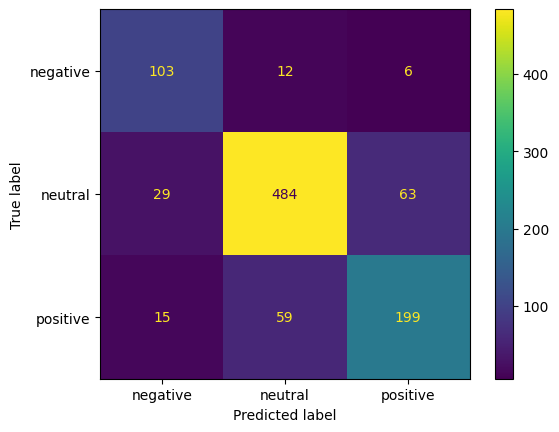

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

# Plot
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()


In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.70      0.85      0.77       121
     neutral       0.87      0.84      0.86       576
    positive       0.74      0.73      0.74       273

    accuracy                           0.81       970
   macro avg       0.77      0.81      0.79       970
weighted avg       0.81      0.81      0.81       970

